# Explore the Autoregressive ++ experiments

In [2]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')

assert data_dir.exists()

In [4]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.utils import get_ds_mask

In [5]:
TRUE_EXPERIMENT = 'one_month_forecast_VCI'
TARGET_VAR =      'VCI'

experiments = [
    "2020_02_14:084457_one_month_forecast_boku_VCI_NOstatic_boku_VCI",
    "2020_02_14:090510_one_month_forecast_VCI_precip_t2m_pet_E_SMroot_SMsurf_NOstatic_VCI",
    "2020_02_14:091317_one_month_forecast_VCI_precip_t2m_pet_E_SMroot_SMsurf_YESstatic_VCI",
]

In [6]:
TRUE_EXPERIMENT = 'one_month_forecast_boku_VCI'
TARGET_VAR =      'boku_VCI'

# EXPERIMENT =      'one_month_forecast_BOKU_boku_VCI_our_vars'
experiment_names = ['ar', 'ar_dynamic', 'ar_dynamic_static']

experiments = [
    "2020_02_14:090033_one_month_forecast_VCI_NOstatic_VCI",
    "2020_02_14:085012_one_month_forecast_boku_VCI_precip_t2m_pet_E_SMroot_SMsurf_NOstatic_boku_VCI",
    "2020_02_14:085848_one_month_forecast_boku_VCI_precip_t2m_pet_E_SMroot_SMsurf_YESstatic_boku_VCI",
]

# Read in the data

In [7]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [8]:
print("TRAINING DATA")
display(ds)
print('\n\n')
print("TARGET DATA")
display(y_test)

TRAINING DATA


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI    (time, lat, lon) float64 100.0 100.0 98.82 ... 11.94 78.34 40.51
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan




TARGET DATA


<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 36)
Coordinates:
  * lat       (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time      (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 64.45 52.16 97.37 96.48 ... nan nan nan

# Load in Predictions

In [9]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

bline = False

model_dict = {}
for EXPERIMENT, experiment_name in zip(experiments, experiment_names):
    model_dict[experiment_name] = {}
    lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
    model_dict[experiment_name]['lstm_pred'] = lstm_pred
    
    # did we run persistence?
    if bline:
        bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
        model_dict[experiment_name]['bline_pred'] = bline_pred
    
    # did we run ealstm?
    if 'static' in experiment_name: 
        ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
        model_dict[experiment_name]['ealstm_pred'] = ealstm_pred

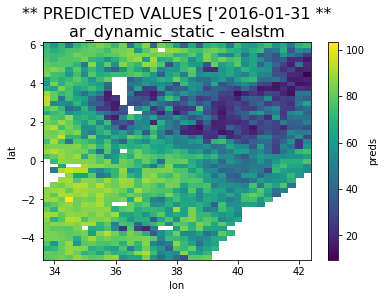

In [10]:
fig, ax = plt.subplots()
time_ix = 0

experiment_name = 'ar_dynamic_static'
time = model_dict[experiment_name]['ealstm_pred'].time.values
model_dict[experiment_name]['ealstm_pred'].isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]} **\n{experiment_name} - ealstm", size=16);

# How did the experiments go?

In [11]:
print(TARGET_VAR)
print(experiment_names)
print(y_test.time.min().values, y_test.time.max().values)

boku_VCI
['ar', 'ar_dynamic', 'ar_dynamic_static']
2016-01-31T00:00:00.000000000 2018-12-31T00:00:00.000000000


In [12]:
from src.analysis import annual_scores

In [13]:
scores_dict = {}

for EXPERIMENT, experiment_name in zip(experiments, experiment_names):
    # load the monthly scores dictionary
    monthly_scores = annual_scores(
        data_path=data_dir,
        models=['rnn', 'ealstm'] if 'static' in experiment_name else ['rnn'],
        metrics=['rmse', 'r2'],
        pred_years=[y for y in range(2016, 2019)],
        experiment=EXPERIMENT,
        true_data_experiment=TRUE_EXPERIMENT,
        target_var=TARGET_VAR,
        verbose=False,
        to_dataframe=True
    )
    monthly_scores['time'] = monthly_scores.apply(lambda row: pd.to_datetime(f"{int(row.month)}-{int(row.year)}"), axis=1)
    
    # store the result to a dictionary
    scores_dict[experiment_name] = monthly_scores

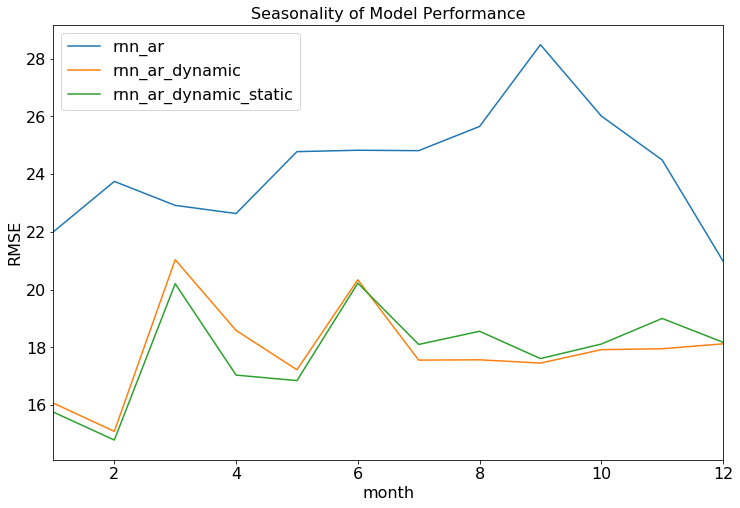

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
for experiment_name in experiment_names:
    monthly_scores = scores_dict[experiment_name]
    
    for model in ['rnn']: # 
        (
            monthly_scores
            .where(monthly_scores.metric == 'rmse')
            .groupby('month').mean().reset_index()
            # .rename(columns={model: f'{model}_{experiment_name}'})
            .plot(x='month', y=model, label=f'{model}_{experiment_name}', ax=ax)
        )
    
    plt.legend(fontsize=16)
    ax.set_title('Seasonality of Model Performance')
    ax.set_ylabel('RMSE');
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
                 + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)

# Pixel Wise Performances

In [15]:
experiment_name = 'ar'
models = [k for k in model_dict[experiment_name].keys()]
model = models[0]

model_dict[experiment_name][model]

<xarray.DataArray 'preds' (time: 36, lat: 45, lon: 35)>
dask.array<where, shape=(36, 45, 35), dtype=float32, chunksize=(1, 45, 35), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * time     (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31

### View the Distributions

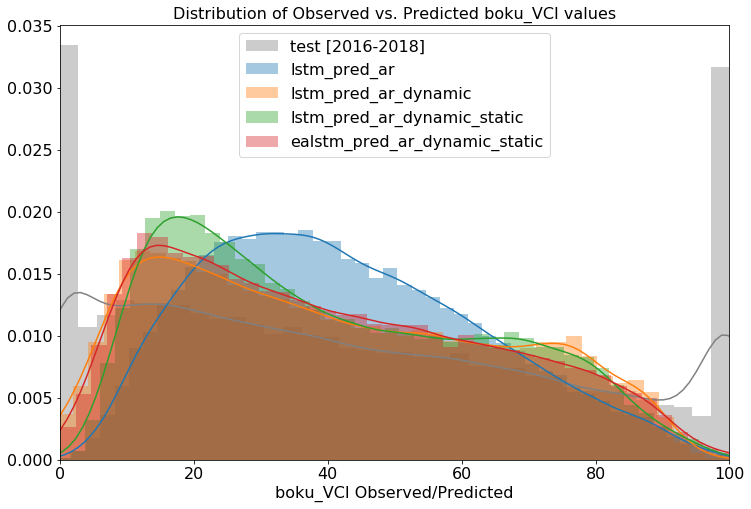

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(drop_nans_and_flatten(y_test[TARGET_VAR]), ax=ax, label='test [2016-2018]', color='grey')

for experiment_name in experiment_names:
    models = [k for k in model_dict[experiment_name].keys()]
    for model in models:
        sns.distplot(drop_nans_and_flatten(model_dict[experiment_name][model]), ax=ax, label=f'{model}_{experiment_name}')

ax.set_xlim([0, 100])
plt.legend(fontsize=16)
ax.set_xlabel(f'{TARGET_VAR} Observed/Predicted');
ax.set_title(f'Distribution of Observed vs. Predicted {TARGET_VAR} values');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
             + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

### View the mean performances

In [17]:
models = [k for k in model_dict[experiment_name].keys()]
models

['lstm_pred', 'ealstm_pred']

In [57]:
from src.analysis import spatial_rmse, spatial_r2

rmse_dict = {}
r2_dict = {}
for experiment_name in experiment_names:
    rmse_dict[experiment_name] = {}
    r2_dict[experiment_name] = {}
    
    # iterate over each model defined for that experiment
    models = [k for k in model_dict[experiment_name].keys()]
    for model in models:
        # ------- RMSE -------
        model_rmse = spatial_rmse(
            y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
            model_dict[experiment_name][model].transpose("time", "lat", "lon")
        )
        rmse_dict[experiment_name][model] = model_rmse
        
        # ------- R2 -------
        model_r2 = spatial_r2(
            y_test[TARGET_VAR].transpose("time", "lat", "lon").sortby(["time", "lat", "lon"]), 
            model_dict[experiment_name][model].transpose("time", "lat", "lon").sortby(["time", "lat", "lon"])
        )
        r2_dict[experiment_name][model] = model_r2


        # calculate mean performance scores
        model_mean = model_rmse.mean().values
        print(f"{experiment_name} {model} mean RMSE: ".ljust(20), f"{model_mean:.2f}")
        
        model_mean = model_r2.mean().values
        print(f"{experiment_name} {model} mean R2: ".ljust(20), f"{model_mean:.2f}")

ar lstm_pred mean RMSE:  25.04
ar lstm_pred mean R2:  0.32
ar_dynamic lstm_pred mean RMSE:  18.13
ar_dynamic lstm_pred mean R2:  0.64
ar_dynamic_static lstm_pred mean RMSE:  18.12
ar_dynamic_static lstm_pred mean R2:  0.64
ar_dynamic_static ealstm_pred mean RMSE:  18.11
ar_dynamic_static ealstm_pred mean R2:  0.64


### How does this look spatially?

In [19]:
experiment_name = 'ar'
model = 'lstm_pred'

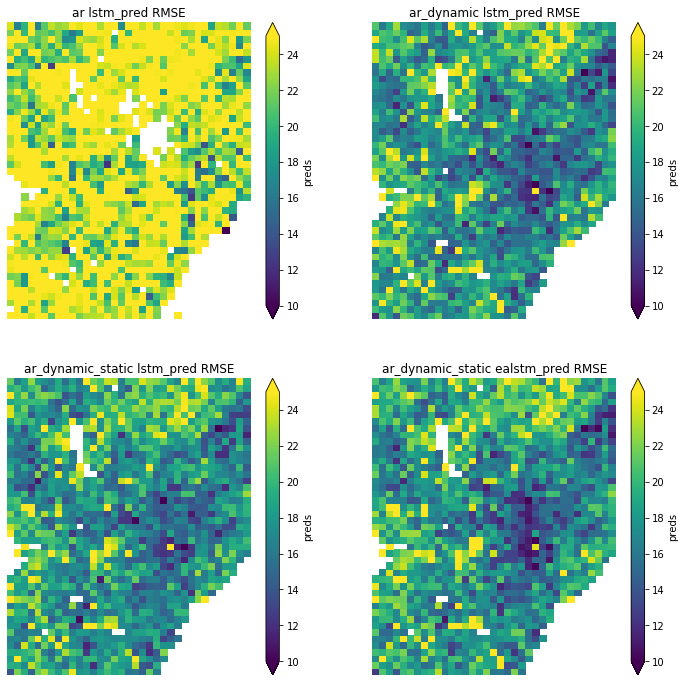

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ix, (experiment_name, model) in enumerate(
    zip(['ar', 'ar_dynamic', 'ar_dynamic_static', 'ar_dynamic_static'],
        ['lstm_pred', 'lstm_pred', 'lstm_pred', 'ealstm_pred'])
):
    ax_ix = np.unravel_index(ix, (2, 2))
    ax = axs[ax_ix]
    # RMSEs
    kwargs = dict(vmin=10, vmax=25)
    rmse_dict[experiment_name][model].plot(ax=ax, **kwargs)
    ax.axis('off')
    ax.set_title(f'{experiment_name} {model} RMSE')

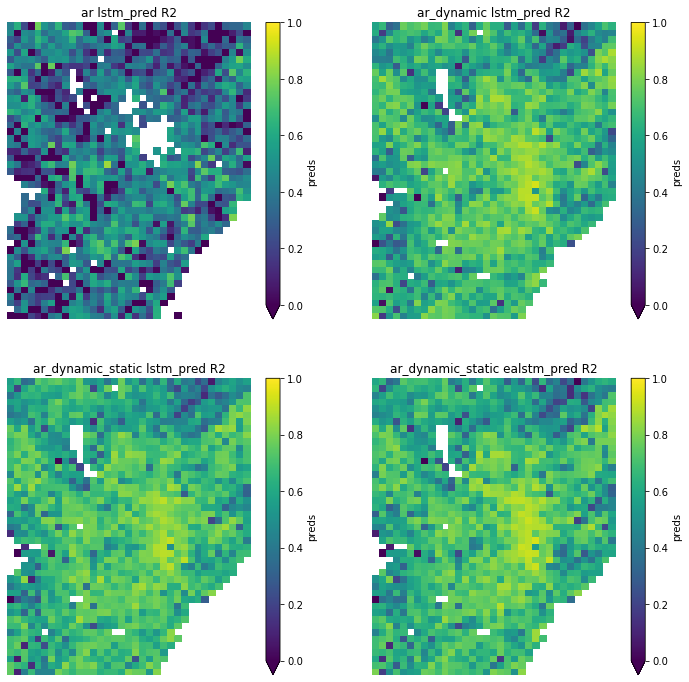

In [58]:
# TODO: spatial_r2 is messing up the axis/dimensions
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ix, (experiment_name, model) in enumerate(
    zip(['ar', 'ar_dynamic', 'ar_dynamic_static', 'ar_dynamic_static'],
        ['lstm_pred', 'lstm_pred', 'lstm_pred', 'ealstm_pred'])
):
    ax_ix = np.unravel_index(ix, (2, 2))
    ax = axs[ax_ix]
    # RMSEs
    kwargs = dict(vmin=0, vmax=1)
    r2_dict[experiment_name][model].plot(ax=ax, **kwargs)
    ax.axis('off')
    ax.set_title(f'{experiment_name} {model} R2')

### And the overall high level overview?

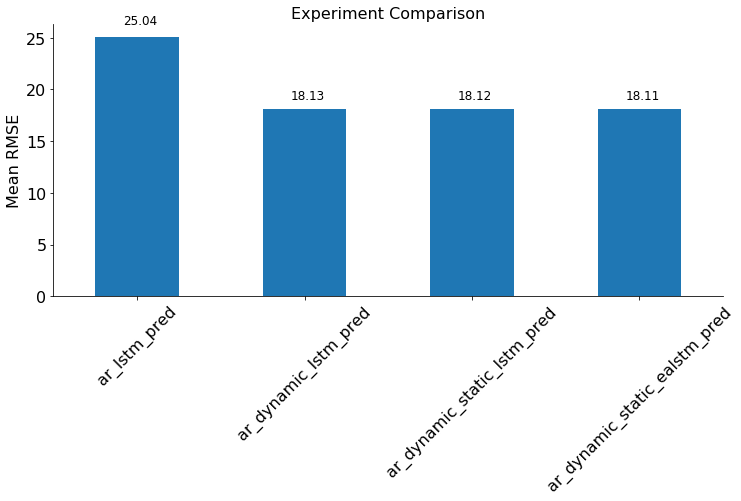

In [54]:
dict_ = {}

for experiment_name in experiment_names:
    models = [k for k in model_dict[experiment_name].keys()]
    for model in models:
        model_rmse = rmse_dict[experiment_name][model]
        dict_[f"{experiment_name}_{model}"] = [np.nanmean(model_rmse.values)]


fig, ax = plt.subplots(figsize=(12, 5))
mean_df = pd.DataFrame(dict_).T.astype(float)
mean_df.plot.bar(ax=ax, legend=False)

ax.set_title('Experiment Comparison')
ax.set_ylabel('Mean RMSE');
plt.xticks(rotation=45)

# 
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] 
             + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",  # annotation (str)
        (p.get_x() + (p.get_width() / 3), p.get_height() * 1.05),  # (x, y) coords
        fontsize=12,
#         fontweight='bold'
    )